In [5]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
import os

In [6]:
def my_skin_detect(src):
    '''
    Start with red > 95 and go from there
    
    
    Function that detects whether a pixel belongs to the skin based on RGB values
    Args: 
        src The source color image
    Returns: 
        dst The destination grayscale image where skin pixels are colored white and the rest are colored black
    Surveys of skin color modeling and detection techniques:
    Vezhnevets, Vladimir, Vassili Sazonov, and Alla Andreeva. "A survey on pixel-based skin color detection techniques." Proc. Graphicon. Vol. 3. 2003.
    Kakumanu, Praveen, Sokratis Makrogiannis, and Nikolaos Bourbakis. "A survey of skin-color modeling and detection methods." Pattern recognition 40.3 (2007): 1106-1122.
    '''
    dst = np.zeros(np.shape(src)[:-1], dtype=np.uint8)
    
    mask = np.logical_and.reduce((src[:,:,0] > 20, src[:,:,1] > 40, src[:,:,2] > 95, 
                                    src.max(axis=-1) - src.min(axis=-1) > 15, 
                                    abs(src[:,:,2] - src[:,:,1]) > 15, 
                                    src[:,:,2] > src[:,:,1], src[:,:,2] > src[:,:,0]))
    
    dst[mask] = 255

    # Too slow
    # for i in range(np.shape(src)[0]):
    #     for j in range(np.shape(src)[1]):
    #         b, g, r = src[i][j]
    #         if r > 95 and g > 40 and b > 20 \
    #             and (max(r, g, b) - min(r, g, b) > 15) \
    #             and abs(r - g) > 15 and r > g and r > b:
    #             dst[i][j] = 255
    kernel = np.ones((7, 7), np.uint8)
    mask = cv2.dilate(dst, kernel, iterations=8)
    return mask

def my_frame_differencing(prev, curr):
    '''
    Function that does frame differencing between the current frame and the previous frame
    Args:
        src The current color image
        prev The previous color image
    Returns:
        dst The destination grayscale image where pixels are colored white if the corresponding pixel intensities in the current
    and previous image are not the same
    '''
    dst = cv2.absdiff(prev, curr)
    gs = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    dst = (gs > 50).astype(np.uint8) * 255
    return dst

def my_motion_energy(mh):
    '''
    Function that accumulates the frame differences for a certain number of pairs of frames
    Args:
        mh Vector of frame difference images
    Returns:
        dst The destination grayscale image to store the accumulation of the frame difference images
    '''
    dst = np.zeros(np.shape(mh[0]), dtype=np.uint8)
    mask = np.logical_or.reduce([m == 255 for m in mh])
    dst[mask] = 255
    return dst

In [7]:
def create_template(template_list, grayscaled=True):
    grayscaled_template_list = []
    for template in template_list:
        if(grayscaled):
            template_grayscaled = cv2.imread(template, cv2.IMREAD_GRAYSCALE)
            grayscaled_template_list.append(template_grayscaled)
        else:
            template_grayscaled = cv2.imread(template, cv2.COLOR_BGR2RGB)
            grayscaled_template_list.append(template_grayscaled)

    return grayscaled_template_list


In [8]:
def show_template(template_list):
    for template in template_list:
        plt.figure(figsize=(10, 10))

        plt.subplot(2, 1, 2)
        plt.imshow(template, cmap = 'gray')
        plt.title('Template')
        plt.axis('off')

        plt.show()

In [9]:
def get_contour(frame):
    contours, hierarchy = cv2.findContours(
       frame, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    frame_cnt = max(contours, key=lambda x: cv2.contourArea(x))
    return frame_cnt


In [10]:
def create_contoured_templates(template_list):
    contoured_templates = []
    for template in template_list:
        contours, hierarchy = cv2.findContours(
            template, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        largest_contour = max(contours, key=lambda x: cv2.contourArea(x))
        contoured_templates.append(largest_contour)

    return contoured_templates

In [11]:
def compare_contours(frame, template_list):
    min_match_value = float('inf')
    best_template_index = None
    
    frame_cnt = get_contour(frame)
    
    for i, template_contour in enumerate(template_list):
       match_value = cv2.matchShapes(
           frame_cnt, template_contour, 1, 0.0)
       if match_value < min_match_value:
           min_match_value = match_value
           best_template_index = i

    if best_template_index == 0:
        print('contour is B')
    elif best_template_index == 1:
        print('contour is C')
    elif best_template_index == 2:
        print('contour is U')
    elif best_template_index == 3:
        print('contour is V')
    

In [12]:
def calculate_circularity(contour):
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    if perimeter == 0:
        return 0 
    circularity = 4 * np.pi * area / (perimeter ** 2)
    return circularity


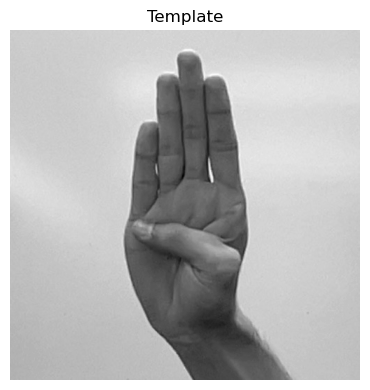

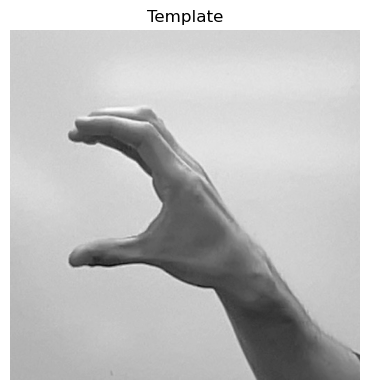

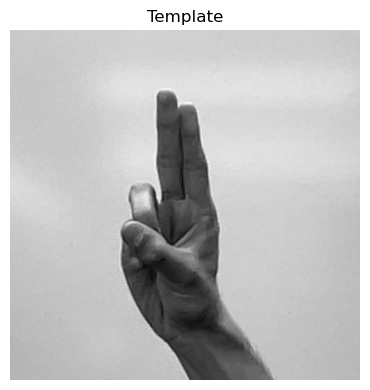

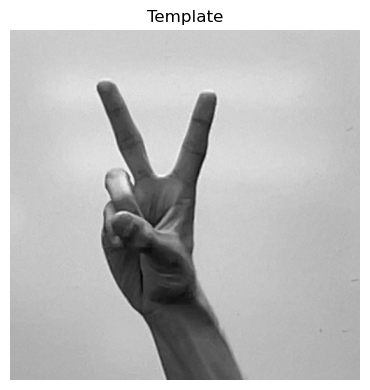

In [13]:
images_list = ['B_img.jpg', 'C_img.jpg', 'U_img.jpg', 'V_img.jpg']
grayscaled_template_list = create_template(images_list)
show_template(grayscaled_template_list)

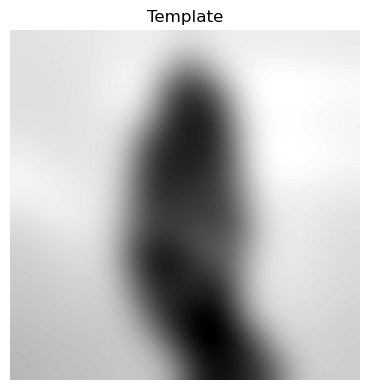

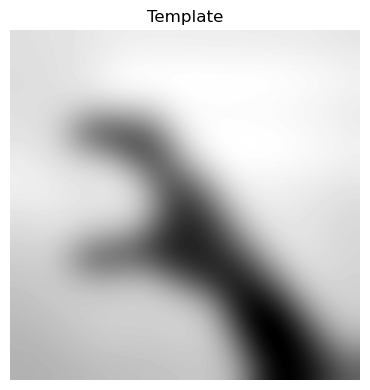

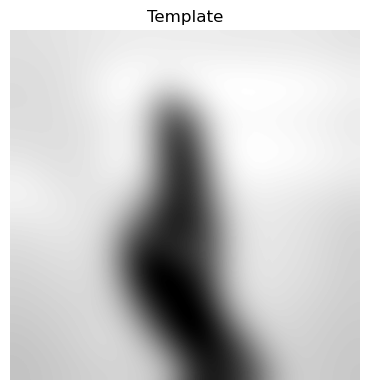

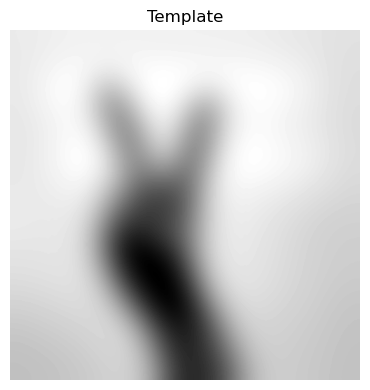

In [14]:
blurred_templates_list = [cv2.GaussianBlur(
    img, (175, 175), 0) for img in grayscaled_template_list]
show_template(blurred_templates_list)


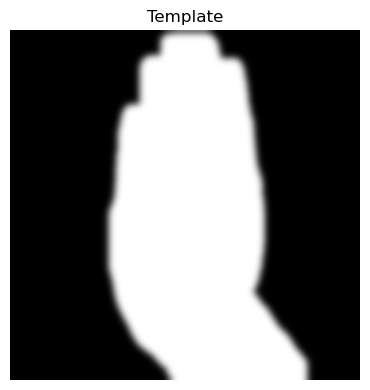

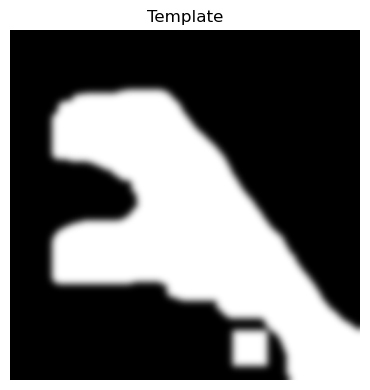

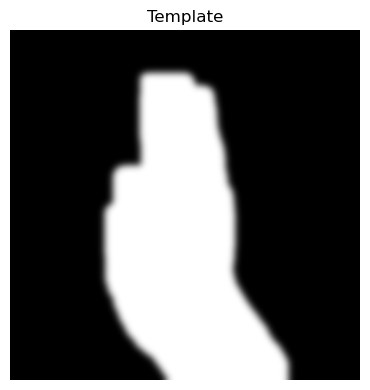

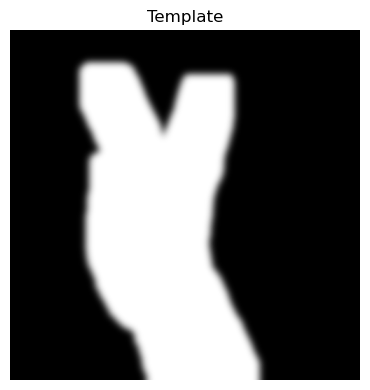

In [15]:
template_list = create_template(images_list, False)
thresholded_templates = [my_skin_detect(template) for template in template_list]

blurred_templates = [cv2.GaussianBlur(
    img, (31, 31), 0) for img in thresholded_templates]
show_template(blurred_templates)


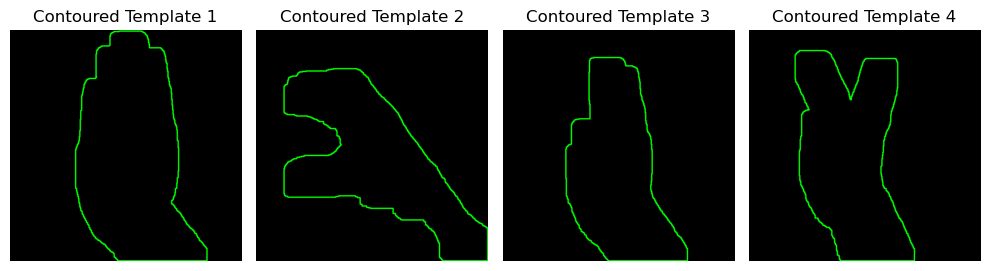

In [16]:
contour_templates = create_contoured_templates(thresholded_templates)

fig, axs = plt.subplots(1, len(contour_templates), figsize=(10, 5))

for i, contour in enumerate(contour_templates):
    # Create a blank canvas with the same dimensions as the template
    canvas = np.zeros_like(template_list[i])
    # Draw the contour on the canvas. Note: OpenCV draws in BGR, matplotlib expects RGB
    cv2.drawContours(canvas, [contour], -1, (0, 255, 0), 2)

    # If the original images are in color, convert the plotted image from BGR to RGB
    if canvas.shape[2] == 3:
        canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)

    # Plotting with Matplotlib
    axs[i].imshow(canvas)
    axs[i].set_title(f"Contoured Template {i+1}")
    axs[i].axis('off')  # Hide axes ticks

plt.tight_layout()
plt.show()


In [17]:
for template in contour_templates:
    print(calculate_circularity(template))

0.5726318916039508
0.3500855020817614
0.5431422721746706
0.42253995651787674


In [22]:
def circulariy_threshold(circularity, template_list):
    if circularity < 0.5:
        return [1]
    elif circularity < 0.66:
        return list(range(1, len(template_list)))
    return list(range(len(template_list)))


In [19]:
def my_template_matcher(frame, template_list, template_names):
    w, h = template_list[0].shape[::-1]
    img = frame.copy()
    similarity_maps = []
    top_lefts = []
    max_vals = []
    for template in template_list:
        similarity_map = np.zeros(
            (img.shape[0] - template.shape[0] + 1, img.shape[1] - template.shape[1] + 1))
        res = cv2.matchTemplate(img, template, cv2.TM_CCORR_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        top_left = max_loc
        bottom_right = (top_left[0] + w,  top_left[1] + h)
        max_vals.append(max_val)
        top_lefts.append(top_left)
        similarity_maps.append(res)

    index_max = max_vals.index(max(max_vals))

    print("Detected hand sign:", template_names[index_max])

    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    bottom_right = (top_lefts[index_max][0] + w,  top_lefts[index_max][1] + h)
    cv2.rectangle(img, top_lefts[index_max], bottom_right, (0, 0, 255), 2)
    plt.figure(figsize=(20, 6))
    plt.subplot(121)
    plt.imshow(res, cmap='gray')
    plt.title('Matching Result')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Detected Point')
    plt.xticks([]), plt.yticks([])
    plt.show()


In [20]:
def determine_hand_sign(frame, template_list):
    template_names = ['B', 'C', 'U', 'V']
    frame_cnt = get_contour(frame)
    frame_circ = calculate_circularity(frame_cnt)
    index_arr = circulariy_threshold(frame_circ, template_list)
    my_template_matcher(frame, template_list[index_arr], template_names[index_arr])


B


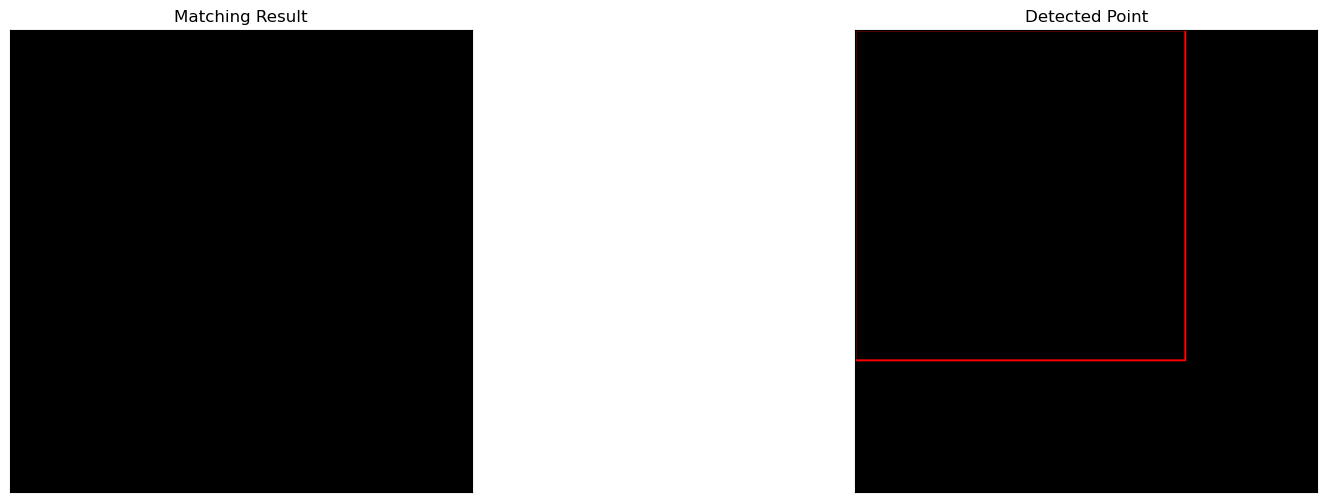

B


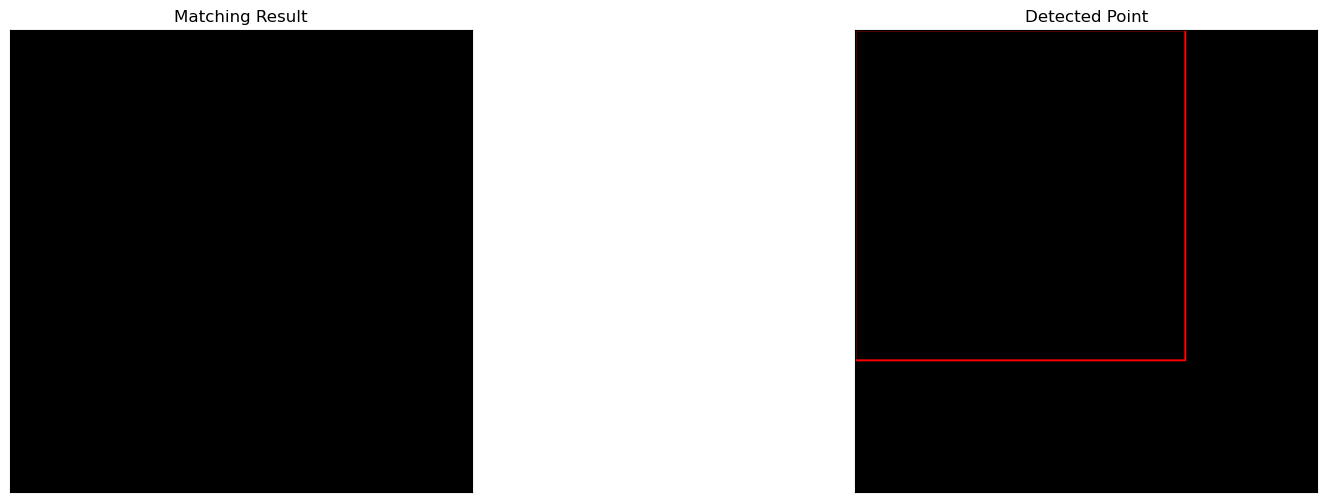

C


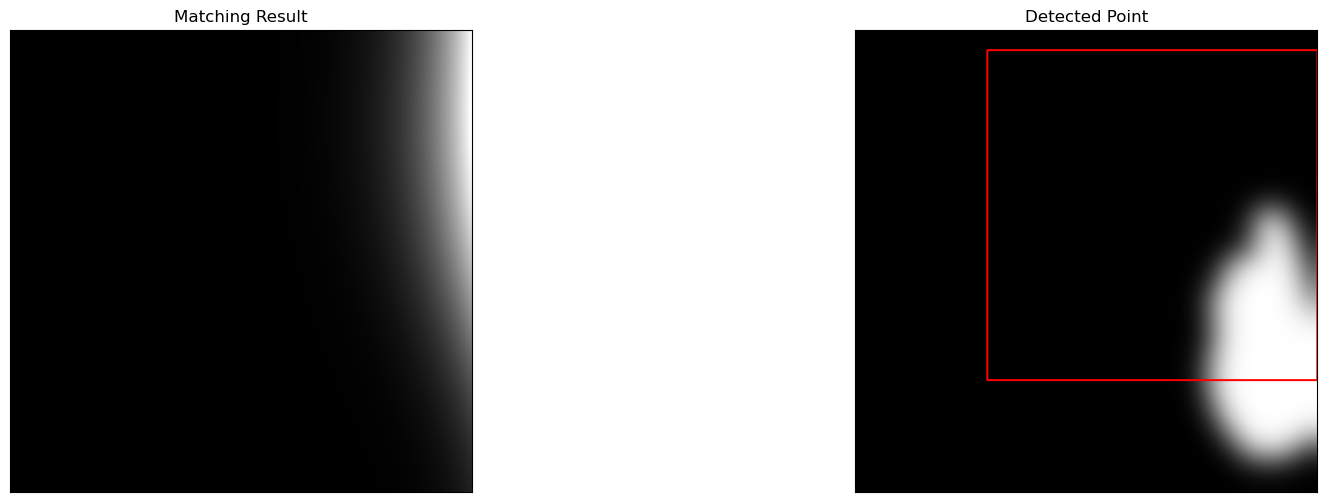

C


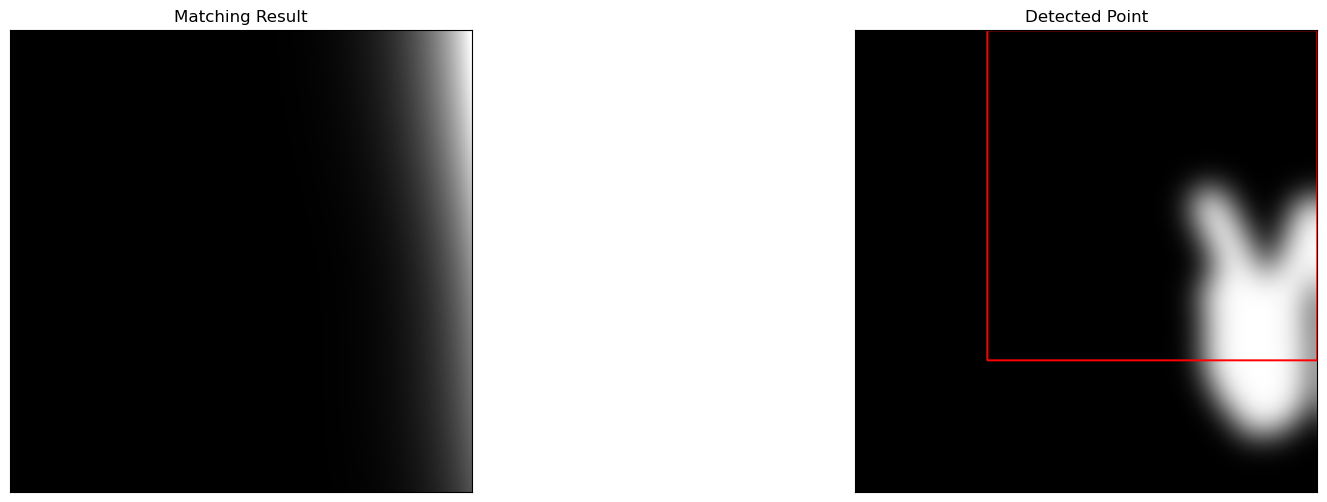

V


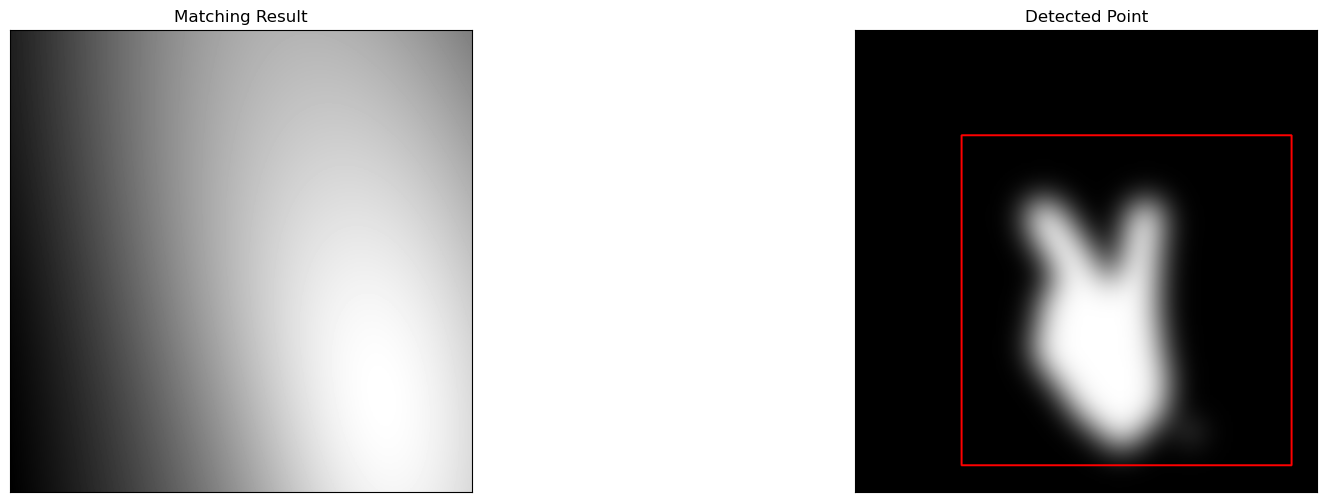

V


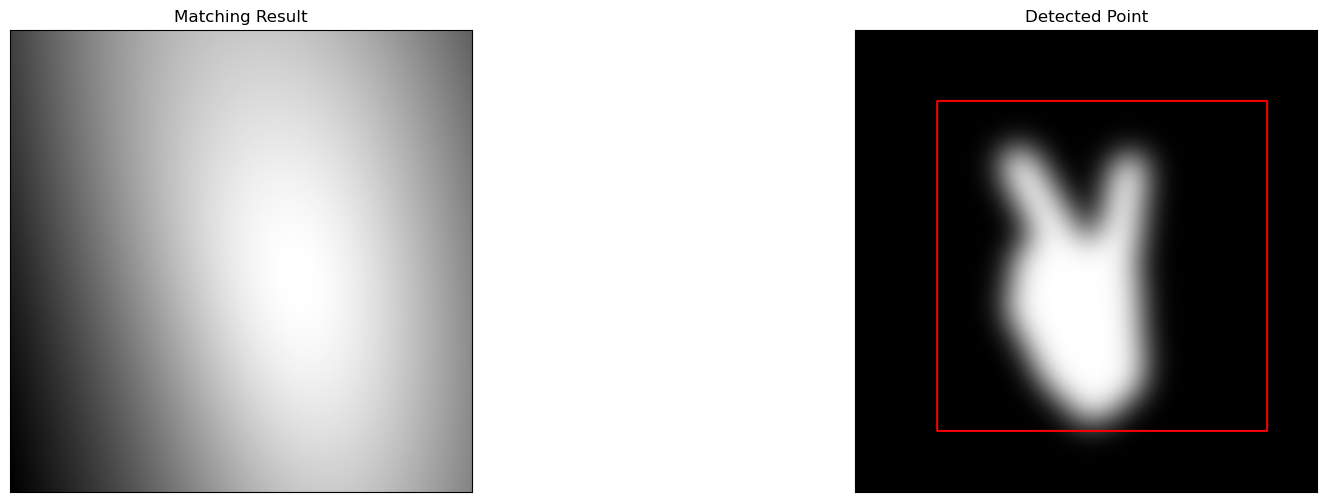

V


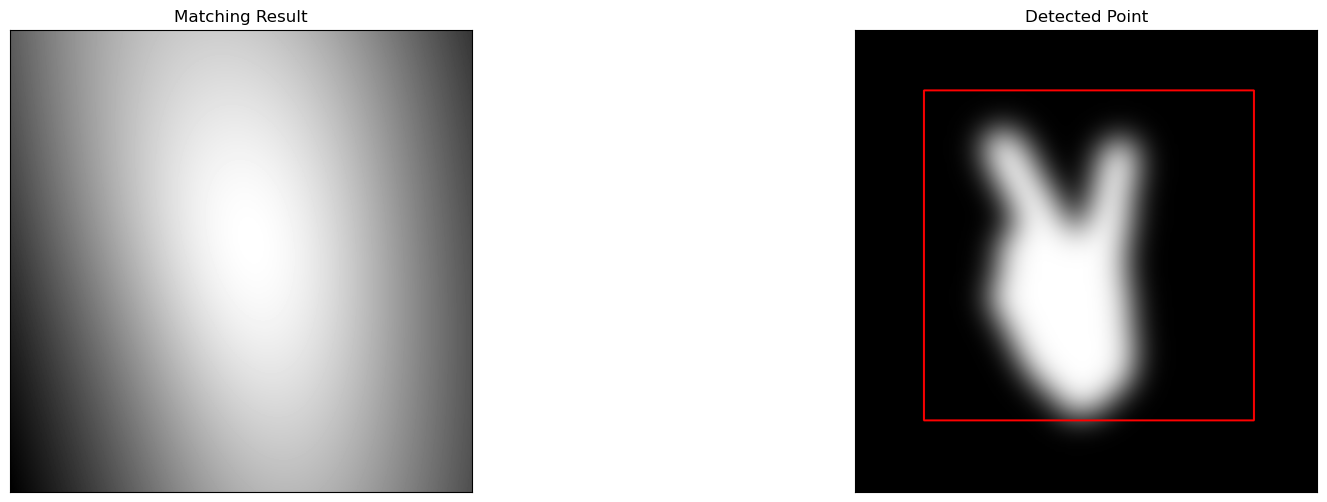

V


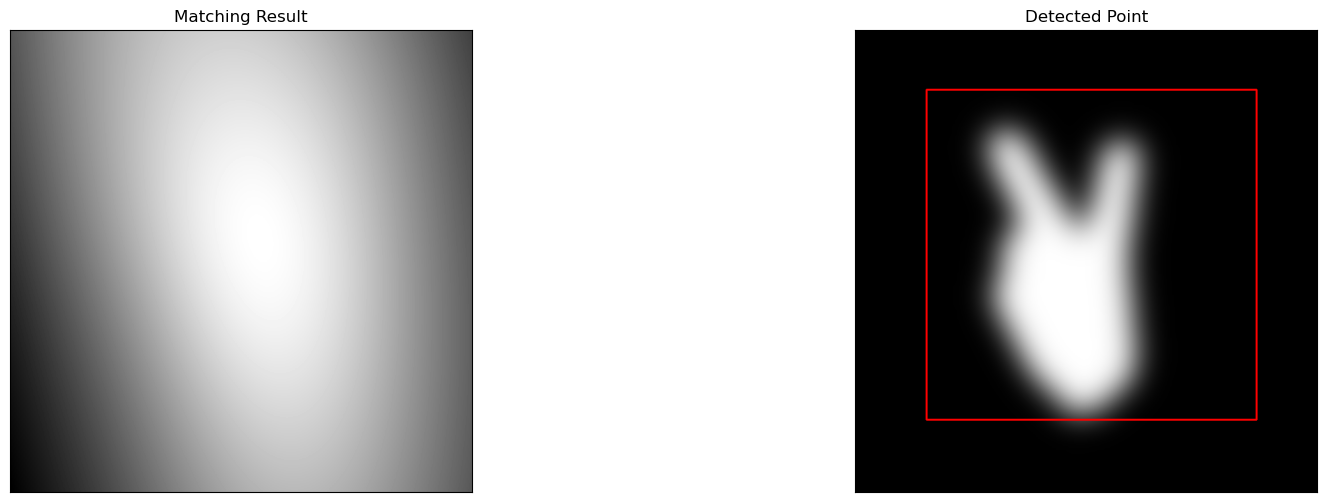

U


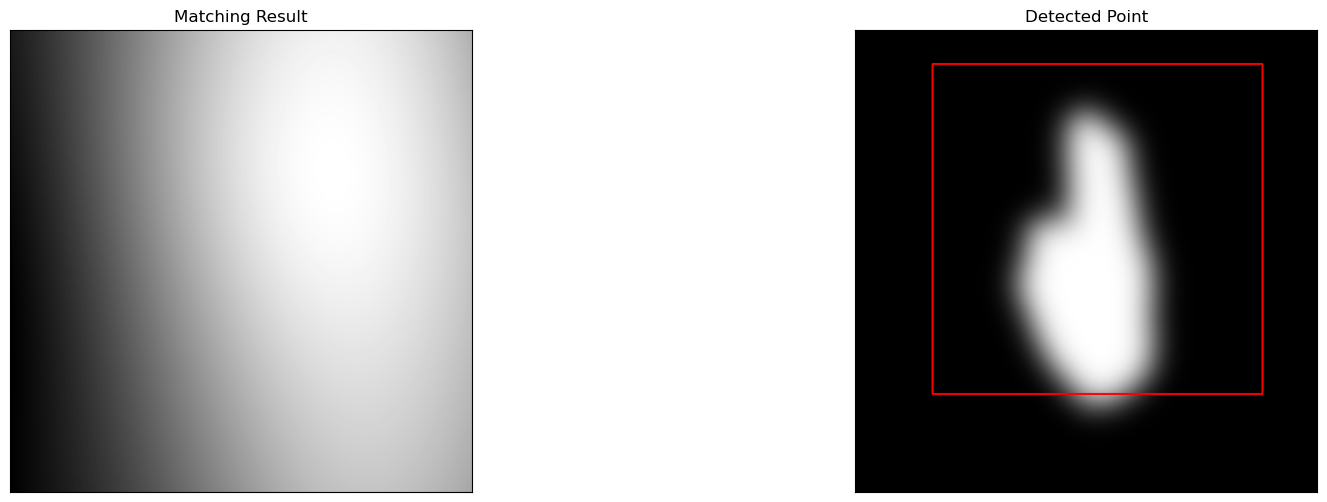

U


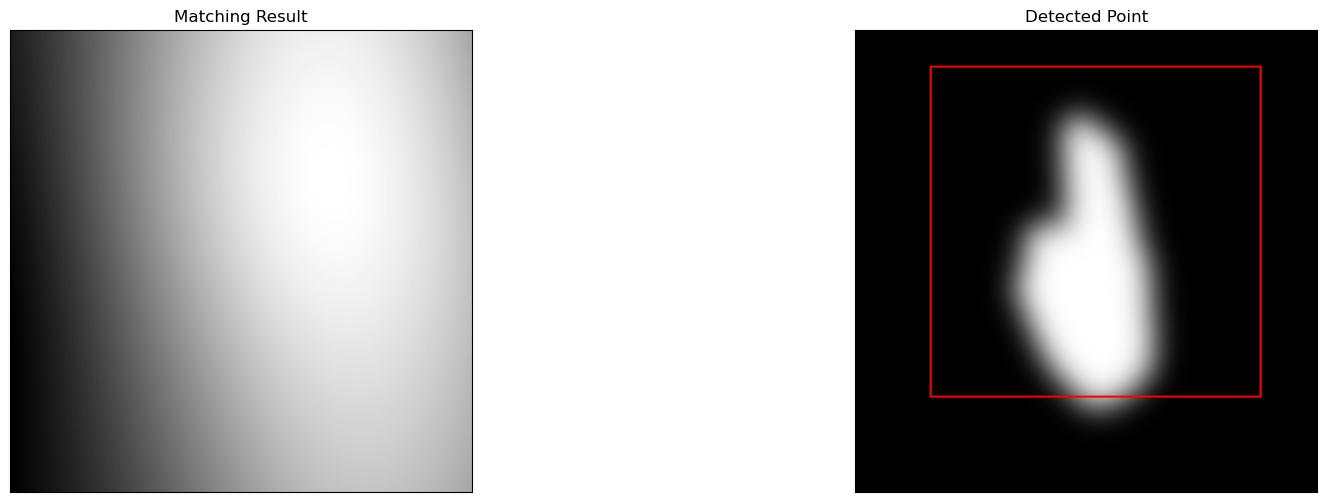

U


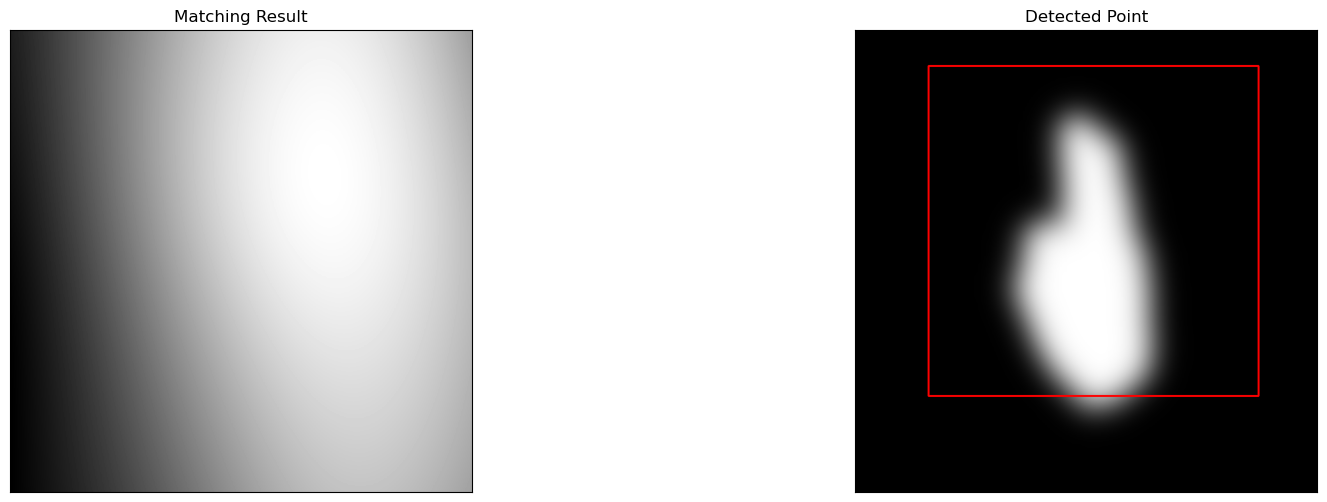

B


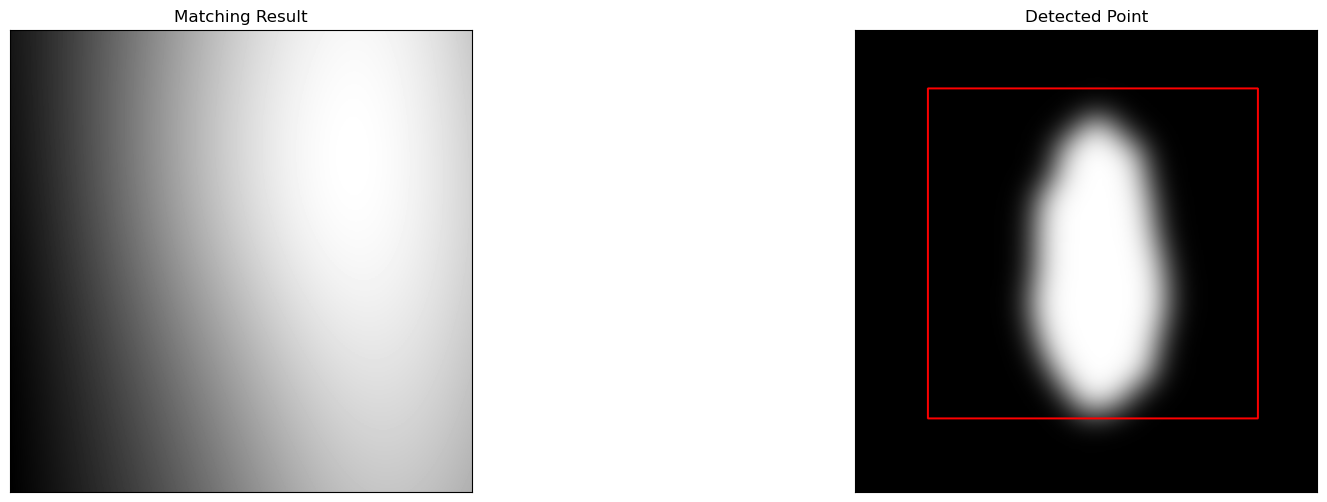

B


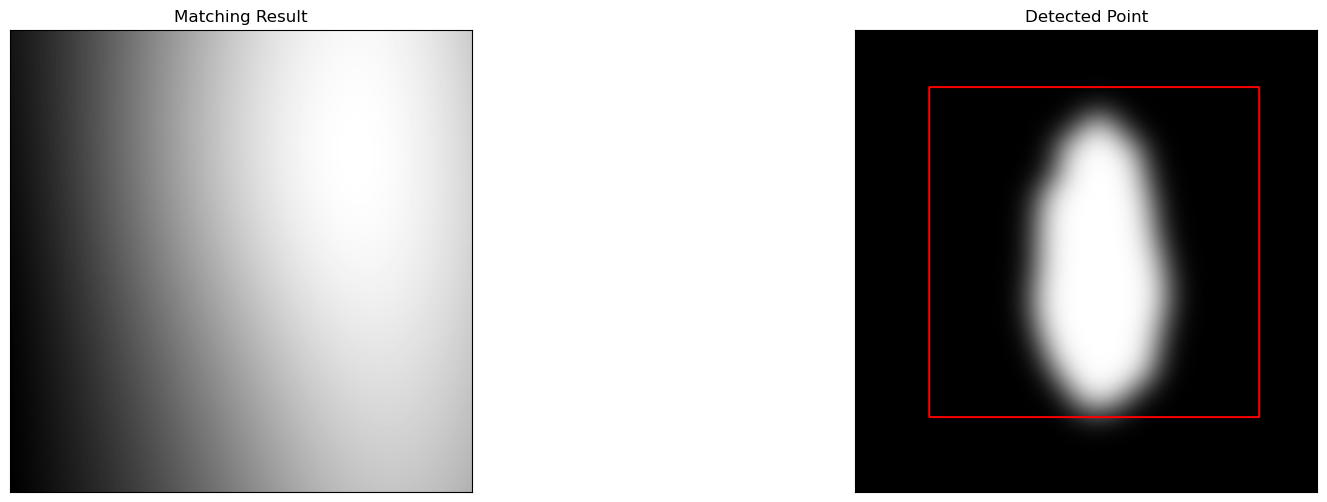

B


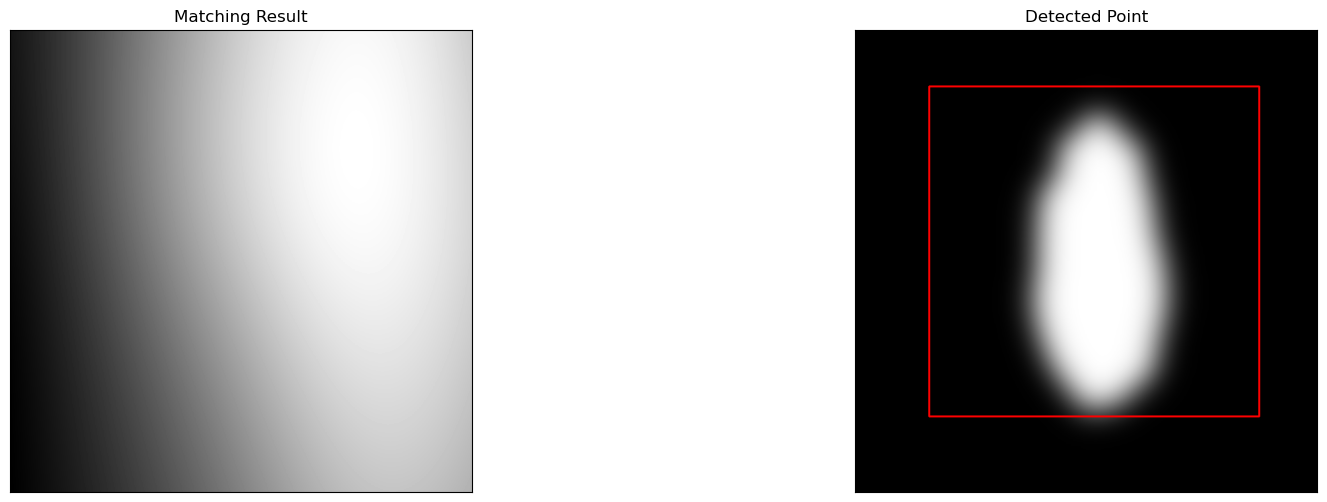

C


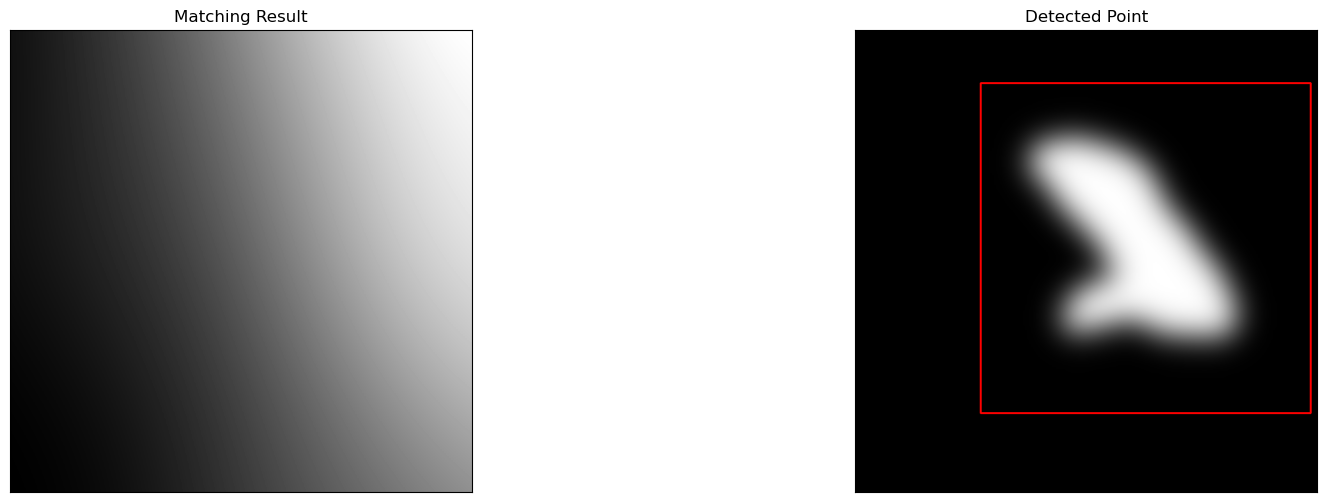

C


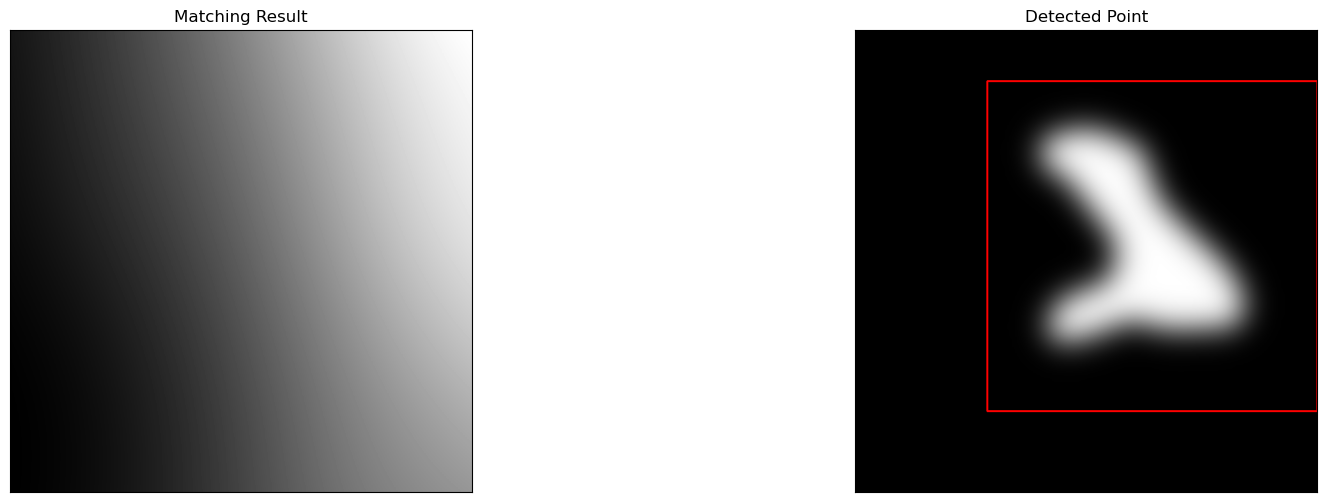

C


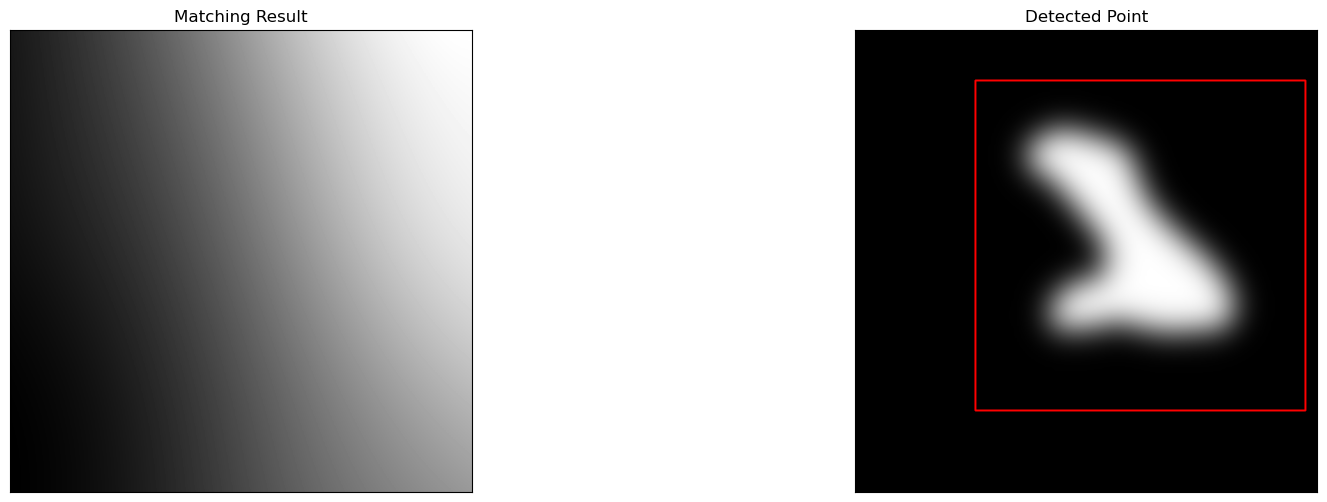

esc key is pressed by user


-1

In [66]:
# ----------------
# a) Reading a stream of images from a webcamera, and displaying the video
# ----------------
# For more information on reading and writing video: http://docs.opencv.org/modules/highgui/doc/reading_and_writing_images_and_video.html
# open the video camera no. 0
cap = cv2.VideoCapture(0)

# if not successful, exit program
if not cap.isOpened():
    print("Cannot open the video cam")
    sys.exit()

# create a window called "MyVideo0"
cv2.namedWindow("MyVideo0", cv2.WINDOW_AUTOSIZE)

# read a new frame from video
ret, frame0 = cap.read()
if not ret:
    print("Cannot read a frame from video stream")
1
# show the frame in "MyVideo" window
cv2.imshow("MyVideo0", frame0)


# create windows
cv2.namedWindow("TemplateMatching", cv2.WINDOW_AUTOSIZE)
kernel = np.ones((5, 5), np.uint8)


while(1):
    # read a new frame from video
    ret, frame = cap.read()
    # if not successful, break loop
    if not ret:
        print("Cannot read a frame from video stream")
        break
    
    
    roi = frame[100:800 , 100:800, :]
    cv2.rectangle(frame, (800,800),(100,100),(0,255,0),3)   
    processed_roi = my_skin_detect(roi)
    eroded_roi = cv2.erode(processed_roi, kernel, 6)
    blurred_roi = cv2.GaussianBlur(processed_roi, (151, 151), 0)
    
    
    
    # ----------------
    #  a) Template Matching
    # ----------------
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    frame[100:800, 100:800] = blurred_roi

    # call my_template_matching function
    my_template_matcher(frame[100:800, 100:800], blurred_templates)

    cv2.imshow("MyVideo0", frame)
    # wait for 'esc' key press for 30ms. If 'esc' key is pressed, break loop
    if cv2.waitKey(1000) == 27:
        print("esc key is pressed by user")
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

In [23]:
# ----------------
# a) Reading a stream of images from a webcamera, and displaying the video
# ----------------
# For more information on reading and writing video: http://docs.opencv.org/modules/highgui/doc/reading_and_writing_images_and_video.html
# open the video camera no. 0
cap = cv2.VideoCapture(0)

# if not successful, exit program
if not cap.isOpened():
    print("Cannot open the video cam")
    sys.exit()

# create a window called "MyVideo0"
cv2.namedWindow("MyVideo0", cv2.WINDOW_AUTOSIZE)

# read a new frame from video
ret, frame0 = cap.read()
if not ret:
    print("Cannot read a frame from video stream")
1
# show the frame in "MyVideo" window
cv2.imshow("MyVideo0", frame0)


# create windows
cv2.namedWindow("TemplateMatching", cv2.WINDOW_AUTOSIZE)
kernel = np.ones((5, 5), np.uint8)


while(1):
    # read a new frame from video
    ret, frame = cap.read()
    # if not successful, break loop
    if not ret:
        print("Cannot read a frame from video stream")
        break

    roi = frame[100:800, 100:800, :]
    cv2.rectangle(frame, (800, 800), (100, 100), (0, 255, 0), 3)
    processed_roi = my_skin_detect(roi)
    eroded_roi = cv2.erode(processed_roi, kernel, 6)
    blurred_roi = cv2.GaussianBlur(processed_roi, (75, 75), 0)

    # ----------------
    #  a) Template Matching
    # ----------------
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    frame[100:800, 100:800] = blurred_roi

    # call my_template_matching function
    
    determine_hand_sign(frame[100:800, 100:800], blurred_templates)    

    cv2.imshow("MyVideo0", frame)
    # wait for 'esc' key press for 30ms. If 'esc' key is pressed, break loop
    if cv2.waitKey(1000) == 27:
        print("esc key is pressed by user")
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)


TypeError: list indices must be integers or slices, not list

In [ ]:
# Load the image and template
